## Load Packages

In [1]:
import re

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats

from sklearn.preprocessing import PowerTransformer, LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer,  TransformedTargetRegressor

from env import *
from plotting.unique import *
from plotting.missing import *
from processing.data import Data

pd.pandas.set_option('display.max_columns', None)

## Import Data

In [2]:

train = Data.from_csv(filepath=DIR_DATA_TRAIN, index_col=COL_ID)
test  = Data.from_csv(filepath=DIR_DATA_TEST, index_col=COL_ID)
print(train)
repr(train)

A dataframe with 1460 rows and 80 columns


'Data(df)'

In [3]:
# Create more human-readable columns
for regex, repl in REGEX_REPL_COLUMN:
    train.columns = train.columns.map(lambda x: re.sub(string=x, pattern=regex, repl=repl))

train.columns = train.columns.map(str.lower)

train.col_target = COL_TARGET

print(f'Columns of training data: {train.columns.tolist()}')

Columns of training data: ['ms_sub_class', 'ms_zoning', 'lot_frontage', 'lot_area', 'street', 'alley', 'lot_shape', 'land_contour', 'utilities', 'lot_config', 'land_slope', 'neighborhood', 'condition_1', 'condition_2', 'building_type', 'house_style', 'overall_quality', 'overall_condition', 'year_built', 'year_remod_add', 'roof_style', 'roof_material', 'exterior1st', 'exterior2nd', 'masonry_veneer_type', 'masonry_veneer_area', 'external_quality', 'external_condition', 'foundation', 'basement_quality', 'basement_condition', 'basement_exposure', 'basement_finished_type_1', 'basement_finished_sq_ft_1', 'basement_finished_type_2', 'basement_finished_sq_ft_2', 'basement_unf_sq_ft', 'total_basement_sq_ft', 'heating', 'heating_quality_condition', 'central_air', 'electrical', '1st_floor_sq_ft', '2nd_floor_sq_ft', 'low_quality_finished_sq_ft', 'ground_liv_area', 'basement_full_bath', 'basement_half_bath', 'full_bath', 'half_bath', 'bedroom_above_ground', 'kitchen_above_ground', 'kitchen_quality'

## Variable Types

In [4]:
train.print_column_types()

There are 43 categorical fields:
['ms_zoning', 'street', 'alley', 'lot_shape', 'land_contour', 'utilities', 'lot_config', 'land_slope', 'neighborhood', 'condition_1', 'condition_2', 'building_type', 'house_style', 'roof_style', 'roof_material', 'exterior1st', 'exterior2nd', 'masonry_veneer_type', 'external_quality', 'external_condition', 'foundation', 'basement_quality', 'basement_condition', 'basement_exposure', 'basement_finished_type_1', 'basement_finished_type_2', 'heating', 'heating_quality_condition', 'central_air', 'electrical', 'kitchen_quality', 'functional', 'fireplace_qu', 'garage_type', 'garage_finish', 'garage_quality', 'garage_condition', 'paved_drive', 'pool_quality_condition', 'fence', 'misc_feature', 'sale_type', 'sale_condition']
There are 37 numerical fields:
['ms_sub_class', 'lot_frontage', 'lot_area', 'overall_quality', 'overall_condition', 'year_built', 'year_remod_add', 'masonry_veneer_area', 'basement_finished_sq_ft_1', 'basement_finished_sq_ft_2', 'basement_unf

In [5]:
train.df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ms_sub_class                1460 non-null   int64  
 1   ms_zoning                   1460 non-null   object 
 2   lot_frontage                1201 non-null   float64
 3   lot_area                    1460 non-null   int64  
 4   street                      1460 non-null   object 
 5   alley                       91 non-null     object 
 6   lot_shape                   1460 non-null   object 
 7   land_contour                1460 non-null   object 
 8   utilities                   1460 non-null   object 
 9   lot_config                  1460 non-null   object 
 10  land_slope                  1460 non-null   object 
 11  neighborhood                1460 non-null   object 
 12  condition_1                 1460 non-null   object 
 13  condition_2                 1460 

## Unique Values

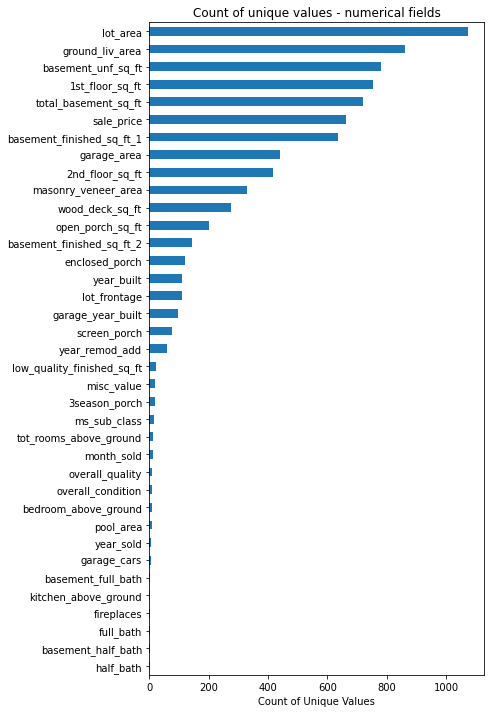

In [6]:
plot_count_unique(train.df, 
                  dtype_include=['float64', 'int64'],
                  title='Count of unique values - numerical fields')

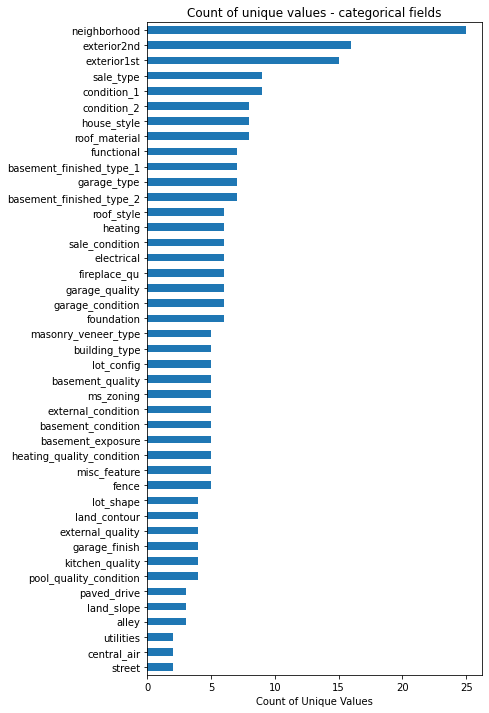

In [7]:
plot_count_unique(train.df, 
                  dtype_include=['O'],
                  title='Count of unique values - categorical fields')

In [8]:
train.remove_constant_columns()

Found 0 constant column(s).
Removed columns:
[]


### Aggregate low count categorical features to 'other' category

In [9]:

#TODO Add unknown category for never-seen-before categories
#TODO Aggregate low count categorical features to 'other' category

CATEGORICAL_AGGREGATION_THRESHOLD = 0.01

col = 'exterior2nd'


train.df[col].value_counts() / train.df[col].value_counts().sum()

VinylSd    0.345205
MetalSd    0.146575
HdBoard    0.141781
Wd Sdng    0.134932
Plywood    0.097260
CmentBd    0.041096
Wd Shng    0.026027
Stucco     0.017808
BrkFace    0.017123
AsbShng    0.013699
ImStucc    0.006849
Brk Cmn    0.004795
Stone      0.003425
AsphShn    0.002055
Other      0.000685
CBlock     0.000685
Name: exterior2nd, dtype: float64

## Missing Values

In [10]:
col_missing_bool = train.df.apply(lambda x: x.isnull().sum() > 0)
col_missing_desc = train.df.columns[col_missing_bool].tolist()

print(f'Columns with missing values:')
print("\n".join(col_missing_desc))

Columns with missing values:
lot_frontage
alley
masonry_veneer_type
masonry_veneer_area
basement_quality
basement_condition
basement_exposure
basement_finished_type_1
basement_finished_type_2
electrical
fireplace_qu
garage_type
garage_year_built
garage_finish
garage_quality
garage_condition
pool_quality_condition
fence
misc_feature


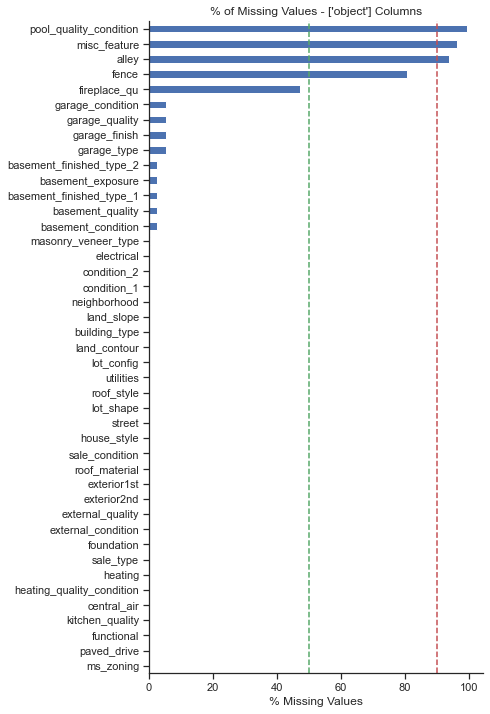

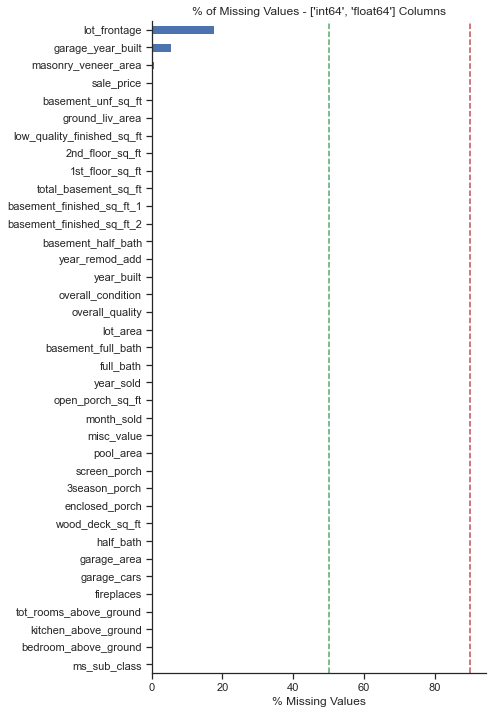

In [11]:
sns.set_theme(
    style="ticks", 
    # palette=sns.color_palette("Set1"), 
    rc=custom_params)

# Plot percentage of missing data
for dtypes in [['object',], ['int64', 'float64']]:

    plot_perc_missing(
        train.df, 
        title=f'% of Missing Values - {dtypes} Columns',
        dtype_include=dtypes,
        )

In [12]:
train.remove_missing_columns(threshold=MISSING_THRESHOLD_DROP)

col_missing_bool = train.df.apply(lambda x: x.isnull().sum() > 0)
col_missing_desc = train.df.columns[col_missing_bool].tolist()

Found 4 column(s) with missing values above the 0.5 threshold.
Removed columns:
['alley', 'pool_quality_condition', 'fence', 'misc_feature']


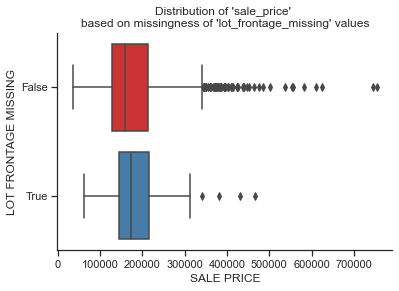

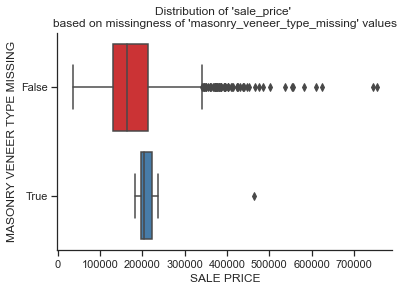

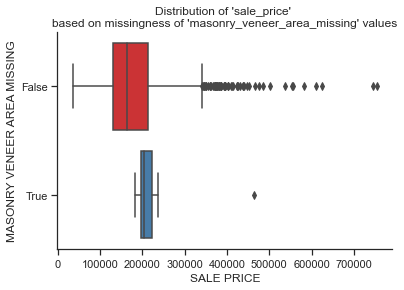

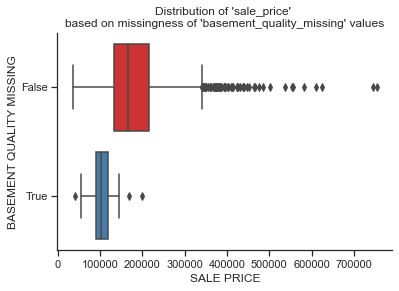

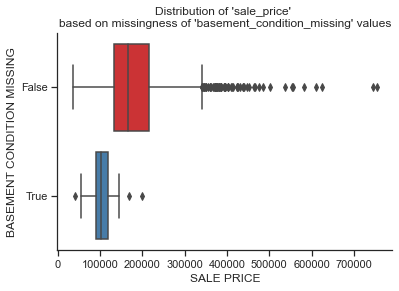

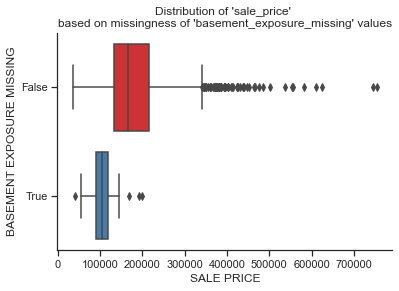

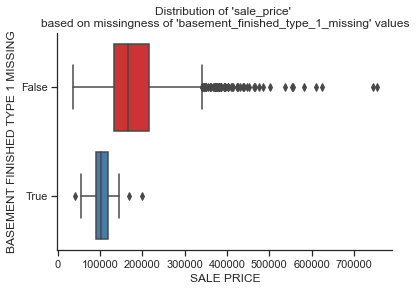

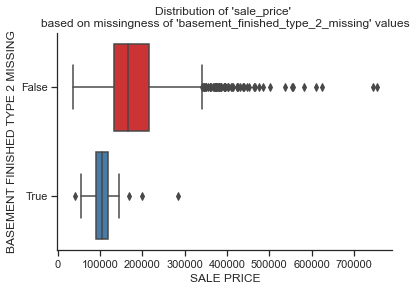

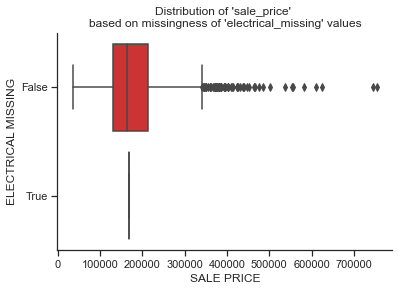

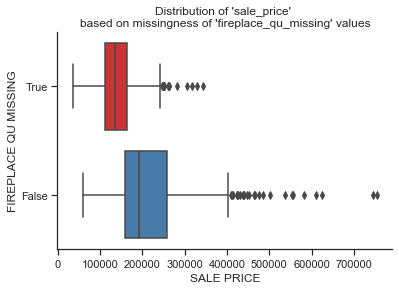

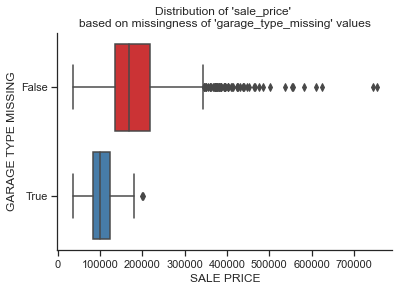

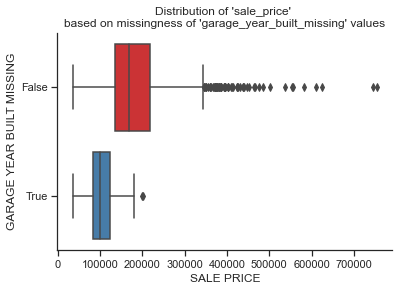

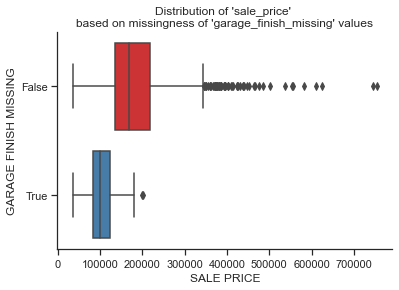

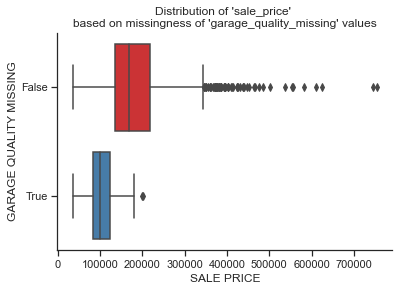

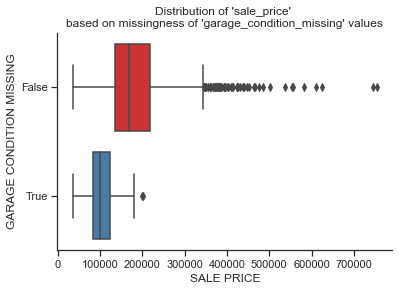

In [13]:
for col in col_missing_desc:

    boxplot_target_missingness_relationship(
        df=train.df, 
        col_var=col, 
        col_target='sale_price'
        )

In [14]:
train.add_flag_missing_values(
    ttest_threshold=FLAG_MISSING_PVALUE_TRESHOLD,
    ttest_min_samples=FLAG_MISSING_MIN_SAMPLES
    )

Skipping 'masonry_veneer_type' due to data size being below threshold 8
Skipping 'masonry_veneer_area' due to data size being below threshold 8
Adding flag for 'basement_quality': p-value below the threshold: 0.0000000
Adding flag for 'basement_condition': p-value below the threshold: 0.0000000
Adding flag for 'basement_exposure': p-value below the threshold: 0.0000000
Adding flag for 'basement_finished_type_1': p-value below the threshold: 0.0000000
Adding flag for 'basement_finished_type_2': p-value below the threshold: 0.0000000
Skipping 'electrical' due to data size being below threshold 1
Adding flag for 'fireplace_qu': p-value below the threshold: 0.0000000
Adding flag for 'garage_type': p-value below the threshold: 0.0000000
Adding flag for 'garage_year_built': p-value below the threshold: 0.0000000
Adding flag for 'garage_finish': p-value below the threshold: 0.0000000
Adding flag for 'garage_quality': p-value below the threshold: 0.0000000
Adding flag for 'garage_condition': p

## Create features from time data

In [15]:
train.df['year_built_or_remod'] = train.df[['year_remod_add', 'year_built']].apply(np.max, axis=1)
train.df['age_garage_when_sold'] = train.df.year_sold - train.df.garage_year_built
train.df['age_house_when_sold'] = train.df.year_sold - train.df.year_built_or_remod

train.drop_columns_regex(regex='year(?!.+missing$)')
train.print_column_types()


Removed columns:
['year_built', 'year_remod_add', 'garage_year_built', 'year_sold']
There are 50 categorical fields:
['ms_zoning', 'street', 'lot_shape', 'land_contour', 'utilities', 'lot_config', 'land_slope', 'neighborhood', 'condition_1', 'condition_2', 'building_type', 'house_style', 'roof_style', 'roof_material', 'exterior1st', 'exterior2nd', 'masonry_veneer_type', 'external_quality', 'external_condition', 'foundation', 'basement_quality', 'basement_condition', 'basement_exposure', 'basement_finished_type_1', 'basement_finished_type_2', 'heating', 'heating_quality_condition', 'central_air', 'electrical', 'kitchen_quality', 'functional', 'fireplace_qu', 'garage_type', 'garage_finish', 'garage_quality', 'garage_condition', 'paved_drive', 'sale_type', 'sale_condition', 'basement_quality_missing', 'basement_condition_missing', 'basement_exposure_missing', 'basement_finished_type_1_missing', 'basement_finished_type_2_missing', 'fireplace_qu_missing', 'garage_type_missing', 'garage_yea

## Discrete Features

In [16]:
# ms_sub_class is a categorical feature
train.change_column_types({'ms_sub_class': 'object'})

Changed 'ms_sub_class' to 'object' type


In [17]:
train.print_column_types()

There are 51 categorical fields:
['ms_sub_class', 'ms_zoning', 'street', 'lot_shape', 'land_contour', 'utilities', 'lot_config', 'land_slope', 'neighborhood', 'condition_1', 'condition_2', 'building_type', 'house_style', 'roof_style', 'roof_material', 'exterior1st', 'exterior2nd', 'masonry_veneer_type', 'external_quality', 'external_condition', 'foundation', 'basement_quality', 'basement_condition', 'basement_exposure', 'basement_finished_type_1', 'basement_finished_type_2', 'heating', 'heating_quality_condition', 'central_air', 'electrical', 'kitchen_quality', 'functional', 'fireplace_qu', 'garage_type', 'garage_finish', 'garage_quality', 'garage_condition', 'paved_drive', 'sale_type', 'sale_condition', 'basement_quality_missing', 'basement_condition_missing', 'basement_exposure_missing', 'basement_finished_type_1_missing', 'basement_finished_type_2_missing', 'fireplace_qu_missing', 'garage_type_missing', 'garage_year_built_missing', 'garage_finish_missing', 'garage_quality_missing', 

In [18]:
discrete_cols = [col for col in train.num_columns if len(train.df[col].unique()) < 20]

train.df[discrete_cols].head(10)

,overall_quality,overall_condition,basement_full_bath,basement_half_bath,full_bath,half_bath,bedroom_above_ground,kitchen_above_ground,tot_rooms_above_ground,fireplaces,garage_cars,pool_area,month_sold
Id,,,,,,,,,,,,,
1,7,5,1,0,2,1,3,1,8,0,2,0,2
2,6,8,0,1,2,0,3,1,6,1,2,0,5
3,7,5,1,0,2,1,3,1,6,1,2,0,9
4,7,5,1,0,1,0,3,1,7,1,3,0,2
5,8,5,1,0,2,1,4,1,9,1,3,0,12
6,5,5,1,0,1,1,1,1,5,0,2,0,10
7,8,5,1,0,2,0,3,1,7,1,2,0,8
8,7,6,1,0,2,1,3,1,7,2,2,0,11
9,7,5,0,0,2,0,2,2,8,2,2,0,4


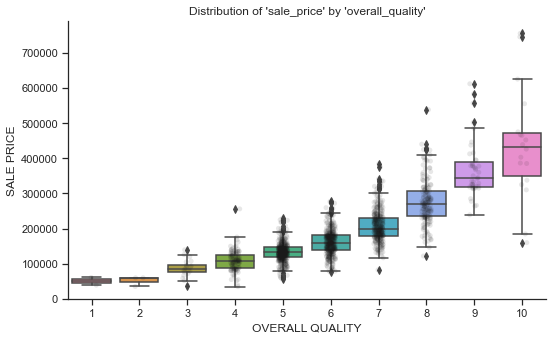

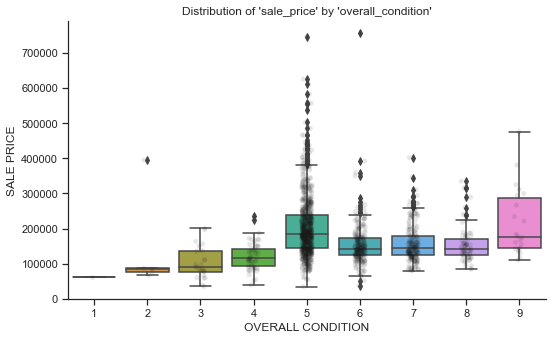

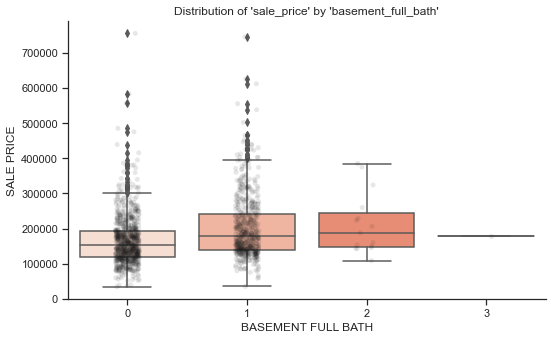

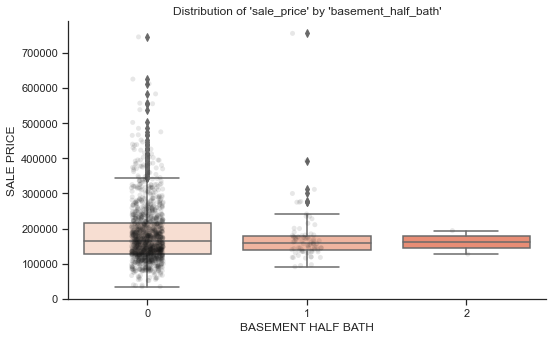

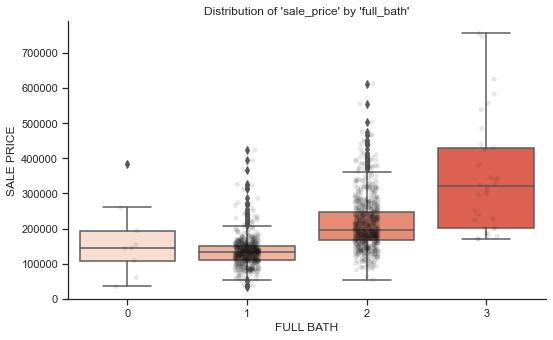

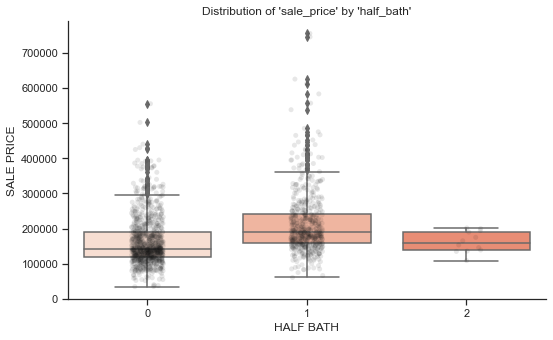

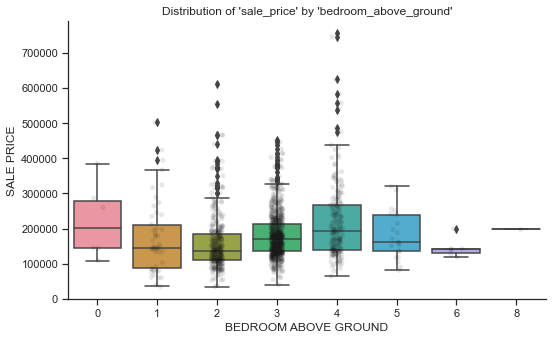

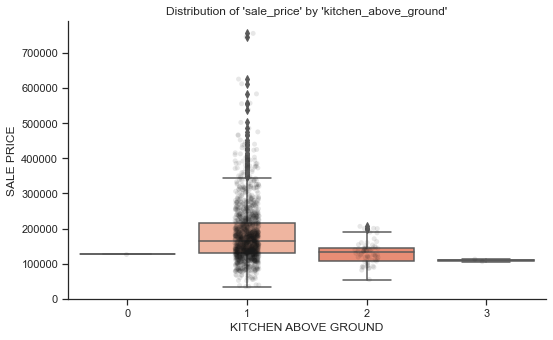

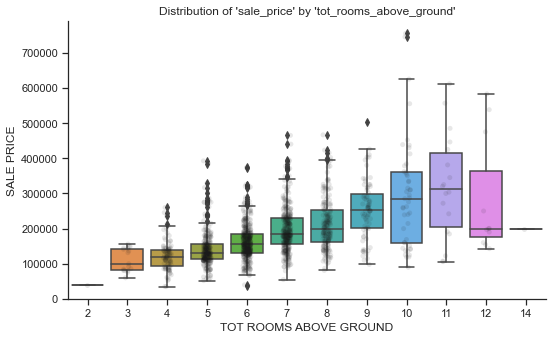

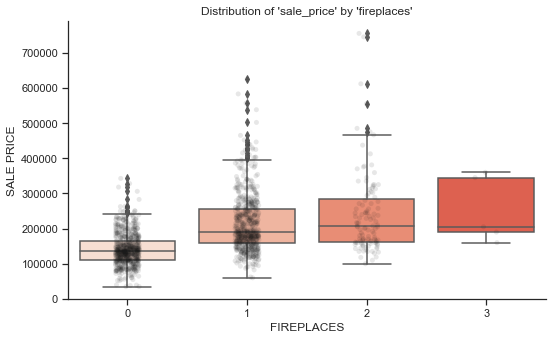

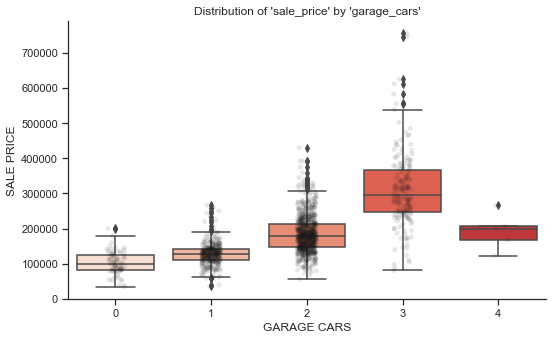

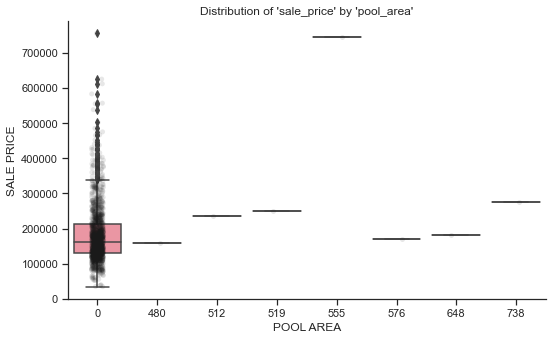

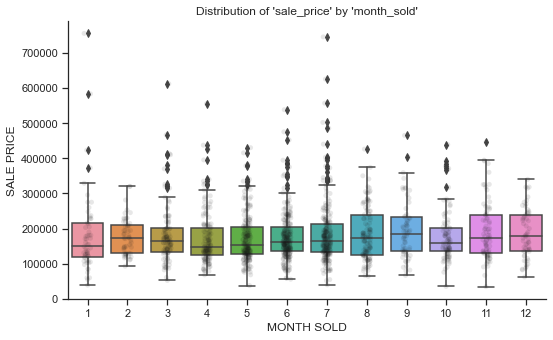

In [19]:
    
for col in discrete_cols:
    
    sns.set_theme(
            style="ticks", 
            palette=sns.color_palette("Reds"), 
            rc=custom_params)
    
    sns.catplot(data=train.df, x=col, y=COL_TARGET, kind='box', height=4.5, aspect=1.7)
    sns.stripplot(data=train.df, x=col, y=COL_TARGET, jitter=0.1, alpha=0.1, color='k')
    plt.title(f'Distribution of \'{COL_TARGET}\' by \'{col}\'')
    plt.ylabel(COL_TARGET.replace('_', ' ').upper())
    plt.xlabel(col.replace('_', ' ').upper())
    plt.show()

## Numerical features

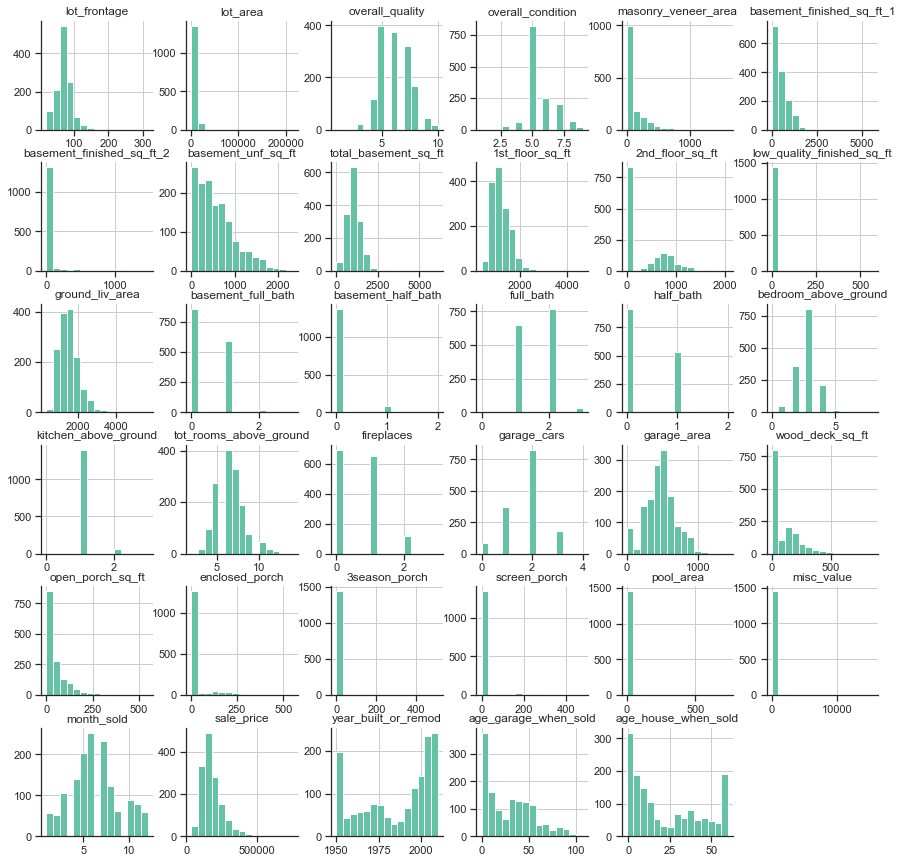

In [20]:
sns.set_theme(
            style="ticks", 
            palette=sns.color_palette("Set2"), 
            rc=custom_params)

train.df[train.num_columns].hist(bins=15, figsize=(15,15))
plt.show()